In [1]:
%load_ext load_style
%load_style talk.css

# EOF analysis - Global SST

In statistics and signal processing, the method of empirical orthogonal function (EOF) analysis is a decomposition of a signal or data set in terms of orthogonal basis functions which are determined from the data. It is similar to performing a principal components analysis on the data, except that the EOF method finds both temporal projections and spatial patterns. The term is also interchangeable with the geographically weighted PCAs in geophysics (https://en.wikipedia.org/wiki/Empirical_orthogonal_functions). The spatial patterns are the EOFs and can be thought of as basis functions in terms of variance. The associated temporal projections are the principal components (PCs) and are the temporal coefficients of the EOF patterns.

* Python EOF library

> The EOF library is used here from Dawson (http://ajdawson.github.io/eofs/).
> eofs is a Python package for EOF analysis of spatial-temporal data. Using EOFs (empirical orthogonal functions) is a common technique to decompose a signal varying in time and space into a form that is easier to interpret in terms of spatial and temporal variance. Some of the key features of eofs are:

> * Suitable for large data sets: computationally efficient for the large output data sets of modern climate models.
> * Transparent handling of missing values: missing values are removed automatically during computations and placed back into output fields.
> * Automatic metadata: metadata from input fields is used to construct metadata for output fields.
> * No Compiler required: a fast implementation written in pure Python using the power of numpy, no Fortran or C dependencies.

* Data Source

> NOAA Optimum Interpolation (OI) Sea Surface Temperature (SST) V2 is downloaded from https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.html.
>
> Spatial Coverage:
> * 1.0 degree latitude x 1.0 degree longitude global grid (180x360).
> * 89.5N - 89.5S, 0.5E - 359.5E.
>
> We select SST from 1982 to 2000.

## 1. Load basic libraries

In [2]:
% matplotlib inline

import numpy as np
from scipy import signal
import numpy.polynomial.polynomial as poly
from netCDF4 import Dataset

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from eofs.standard import Eof

## 2. Load SST and mask data

### 2.1 Read SST

In [3]:
infile = 'data\sst.mnmean.nc'
ncin = Dataset(infile, 'r')
sst  = ncin.variables['sst'][1:229,:,:] #1982 to 2000
lat  = ncin.variables['lat'][:]
lon  = ncin.variables['lon'][:]
ncin.close()

nt,nlat,nlon = sst.shape    
print(sst.shape )

(228L, 180L, 360L)


### 2.2 Read mask (1=ocen, 0=land)

In [4]:
lmfile = 'data\lsmask.nc'
lmset  = Dataset(lmfile)
lsmask = lmset['mask'][0,:,:]# read land mask
lsmask = lsmask-1

num_repeats = nt
lsm = np.stack([lsmask]*num_repeats,axis=-1).transpose((2,0,1))
lsm.shape

(228L, 180L, 360L)

## 3. Detrend and remove seasonal cycle 

Here we used the detrend from scipy.signal. See help: signal.detrend?

### 3.1 Rearrange data for seasonal removal

In [5]:
sst = sst.reshape((nt,nlat*nlon), order='F')
sst_detrend = signal.detrend(sst, axis=0, type='linear', bp=0)
sst_detrend = sst_detrend.reshape((12,nt/12, nlat,nlon), order='F').transpose((1,0,2,3))

print(sst_detrend.shape)

(19L, 12L, 180L, 360L)


x = np.empty((nt))
sst_coeffs  = np.empty((2, nlat, nlon))
sst_detrend = np.empty((nt, nlat, nlon))

for i in range(0, nt):
  x[i] = i

for i in range(0,nlat):
  for j in range(0,nlon):
    ytemp = np.copy(sst[:,i,j])
    y = sst[:,i,j]
    b = ~np.isnan(y)
    coefs = poly.polyfit(x[b], y[b], 1)
    sst_coeffs[0,i,j] = coefs[0]
    sst_coeffs[1,i,j] = coefs[1]
    ffit = poly.polyval(x[b], coefs)
    sst_detrend[b,i,j] = y[b] - ffit
    
sst_detrend = sst_detrend.reshape((12,nt/12, nlat,nlon), order='F').transpose((1,0,2,3))

### 3.2 Calculate seasonal cycle

In [6]:
sst_season = np.mean(sst_detrend, axis=0)

### 3.3 Remove seasonal cycle

In [7]:
sst_diff = sst_detrend - sst_season
sst_diff = sst_diff.transpose((1,0,2,3)).reshape((nt, nlat,nlon), order='F')

### 3.4 Mask out land

It is worth note that scipy.sigal.detrend does not support nan values. Therefore, we put masking here instead of beginning.

In [8]:
sst_diff = np.ma.masked_array(sst_diff, mask=lsm)
sst_diff[lsm<0] = np.nan

## 4. Carry out EOF analysis

### 4.1 Create an EOF solver to do the EOF analysis

Cosine of latitude weights are applied before the computation of EOFs. 

In [9]:
wgts   = np.cos(np.deg2rad(lat))
wgts   = wgts.reshape(len(wgts), 1)
solver = Eof(sst_diff, weights=wgts)

### 4.3 Retrieve the leading EOFs

Expressed as the correlation between the leading PC time series and the input SST anomalies at each grid point, and the
leading PC time series itself.

In [10]:
eof1 = solver.eofs(neofs=10)
pc1  = solver.pcs(npcs=10, pcscaling=0)
varfrac = solver.varianceFraction()
lambdas = solver.eigenvalues()

## 5. Visualize leading EOFs

### 5.1 Plot EOFs and PCs

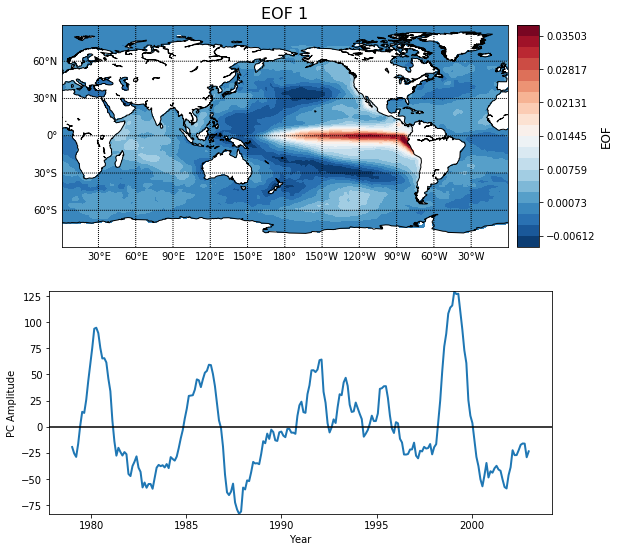

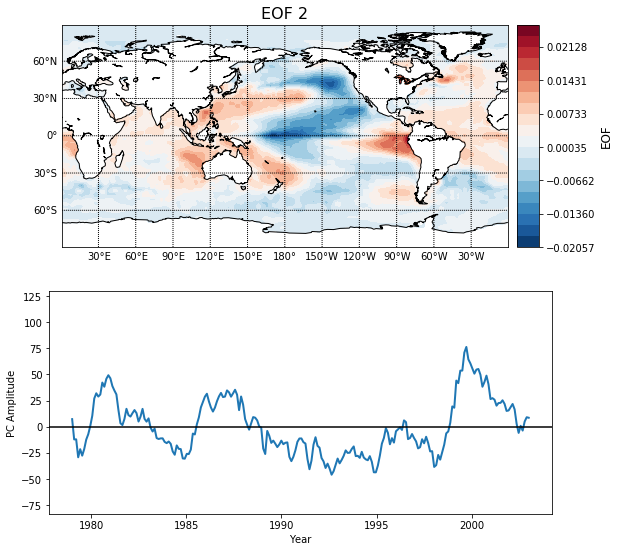

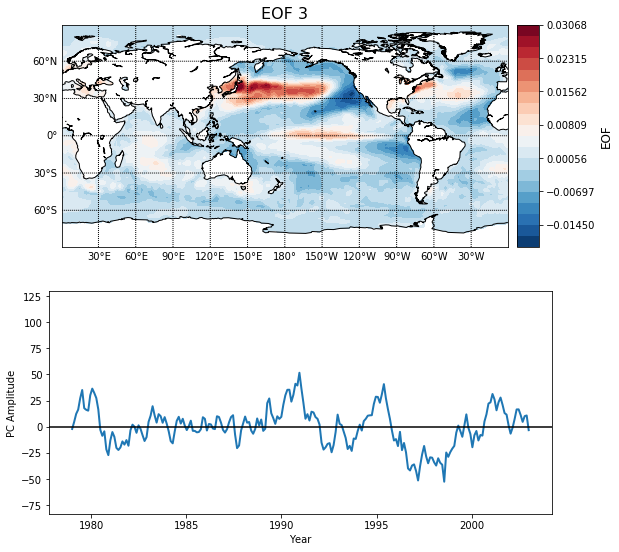

In [11]:
parallels = np.arange(-90,90,30.)
meridians = np.arange(-180,180,30)

for i in range(0,3):
    fig = plt.figure(figsize=(9,9))
    plt.subplot(211)
    
    m = Basemap(projection='cyl', llcrnrlon=min(lon), llcrnrlat=min(lat), urcrnrlon=max(lon), urcrnrlat=max(lat))    
    x, y = m(*np.meshgrid(lon, lat))
    clevs = np.linspace(np.min(eof1[i,:,:].squeeze()), np.max(eof1[i,:,:].squeeze()), 21)
    cs = m.contourf(x, y, eof1[i,:,:].squeeze(), clevs, cmap=plt.cm.RdBu_r)
    m.drawcoastlines()  
    m.drawparallels(parallels, labels=[1,0,0,0])
    m.drawmeridians(meridians, labels=[1,0,0,1])

    cb = m.colorbar(cs, 'right', size='5%', pad='2%')
    cb.set_label('EOF', fontsize=12)
    plt.title('EOF ' + str(i+1), fontsize=16)

    plt.subplot(212)
    days = np.linspace(1979,2003,nt)
    plt.plot(days, pc1[:,i], linewidth=2)
    plt.axhline(0, color='k')
    plt.xlabel('Year')
    plt.ylabel('PC Amplitude')   
    plt.ylim(np.min(pc1.squeeze()), np.max(pc1.squeeze()))    

The spatial pattern of EOF1 is the canonical El Nino pattern, and the associated time series shows large peaks and troughs for well-known El Nino and La Nina events.

### 5.2 Check variances explained by leading EOFs

(3.8409178e-16, 0.23554320096969605)

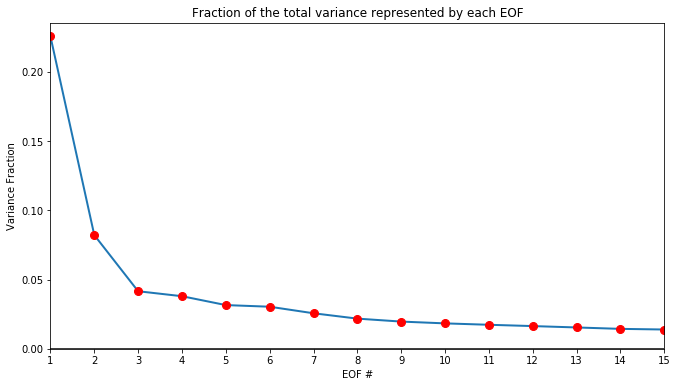

In [12]:
plt.figure(figsize=(11,6))
eof_num = range(1, 16)
plt.plot(eof_num, varfrac[0:15], linewidth=2)
plt.plot(eof_num, varfrac[0:15], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 15)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

## References

http://unidata.github.io/netcdf4-python/

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011), DOI:10.1109/MCSE.2011.37

Kalnay et al.,The NCEP/NCAR 40-year reanalysis project, Bull. Amer. Meteor. Soc., 77, 437-470, 1996.